Throughput Data Reduction Walkthrough

The purpose of this file is to walk future DRRP users through taking throughput measurements on bench. The functions written specifically for this process can be found in throughput_module.py 

Imports:

In [1]:
import glob
import throughput_module as tm
import os
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
#import dark_subtraction as ds
from scipy.ndimage import center_of_mass
import shutil as su

Taking throughput meaurements requires 4 steps:

1. Cleaning the Data 

2. Dark Subtraction 

3. Normalization Using Photodiode Readings

4. Aperture Summing (to obtain final throughput values)

This file walks throgh these steps sequentially and explains why they should be done

Data Format:

- fits files containing any number of frames in a data cube 
- a fits header OPMPOWER containing a photodiode reading for each individual frame
- general file struture for measurement, air calibtration frame, dark frame:
    Data_Measurement_1100nm_tint_15.0_fps_10.0_cam_temp_-40_overall_power_100_channel_power_100
    Air_Measurement_1100nm_tint_15.0_fps_10.0_cam_temp_-40_overall_power_100_channel_power_100
    Dark_Measurement_1100nm_tint_15.0_fps_10.0_cam_temp_-40

1. Cleaning the Data:

This step originates from the JHK waveplate data set (from spring 2025). The CRED2 had a tendancy to wrap certain frames; frame wrapping moves the beam off the usual center point and often split it between the ends of the screen. This is bad, because it significantly reduces the median pixel value, thus returning an artificially deflated throughput (or inflated if the air calibtration frames are wrapped). I remove these files from the data set.

Unfortunately, I have not been able to think of a better way to identify faulty frames than scrolling through the fits files manually (in SAO). This will take some time, but is worth doing. If you get to the end of this process and find individual measurements have anomylously large or small throughput readings, it is worth cracking those files open to check for wrapping. The effects are not always obvious, but odd looking data points are a good place to start. 

The function for splicing the data is:
splice_data(directory, file_name, ranges, scrap_savepath)

Going through inputs:

    directory (str) - self explanatory; this is the greater folder containing all measurements (calibtration and dark frames included) for tthe data set

    file_name (str) - copy and pasted name of the file to be spliced

    ranges (list of 2 index tuples) - ranges tells this function what images to keep...for example, if you have a 100 image set where images 10-20 and 30-40 are faulty, ranges should read: [(0,9),(20,29),(40,100)]. As a rule of thumb, you will keep the first index of the tuple, but will not keep the second index of the tuple. 

    scrap_savepath (str) - name of folders where the original files will be sent to. We don't want to delete data. Instead, any files spliced will have the unspliced originals saved to this dirstory with '_scrap' added just before .fits


In [ ]:
# I AM INTENTIONALLY LEAVING THIS EMPTY SO THAT RUNNING THE SCRIPT WILL NOT ACCIDENTALLY SPLICE DATA
directory = 'D:\\20250514_NIRC2_JHK_Waveplate_Throughput'
file_name = 
ranges = 
scrap_savepath = 
tm.splice_data(directory, file_name, ranges, scrap_savepath)

2. Dark Subtraction

After removing wrapped images from the set, we can begin reducing the data. 

Removing wrapped images BEFORE dark subtraction is especially important becuase of the CRED2's prominent dark current pattern. The pattern appears as either vertical lines or a crosshatch pattern. The thing to not is that they are well defined 'features' in the final image. This pipeline does dark subtraction pixel by pixel rather than as a flat threshold for that reason. If wrapped images are not removed from the set, these 'features' will be missaligned and thus not effectively removed from the background. 

For each wavelength, MAKE SURE THE DARK FRAMES HAVE THE SAME INTEGRATION TIME AS THE LIGHT FRAMES, as there is no built in conversion method yet. The dark for each wavelength is created by taking the median pixel value of the dark frames taken at that wavelength. 

The function 'dark_subtract_2(...)' will produce fits files with the same name as the raw data, in the same folder as the raw data, with '_dsub' appended to the file name before the '.fits'. For example:

'Data_Measurement_1100nm_tint_15.0_fps_10.0_cam_temp_-40_overall_power_100_channel_power_100.fits' 
-->
'Data_Measurement_1100nm_tint_15.0_fps_10.0_cam_temp_-40_overall_power_100_channel_power_100_dsub.fits'

The file should be the exact same size as the raw data, conaining a data cube with the same dimensions as the original + all the attached headers.

NOTE: the variable 'wvls' (short for wavelengths), should be a list (or array) of strings. For example:
wvls = ['1100','1200','1300',...,'1900']

In [3]:
# make sure to double-slash all directory / path strings...ie \ --> \\
directory = 'D:\\20250514_NIRC2_JHK_Waveplate_Throughput'
wvls = ['1100','1200','1300','1400','1500','1600','1700','1800','1900']
tm.dark_subtract_2(directory,wvls)

More than one air_cal frame detected for wvl: 1100


False

3. Normalization

Normalization uses the photodiode measurements to account for fluctuations in the power output by the lazer. We perform this process in two steps. 

First, we normalize the photodiode readings. These are stored in the header 'OPMPOWER' and should be viewable in either the raw or _dsub fits files. We are basing our throughput on the counts measured in the air calibtraion frame, so we normalize the (median) power recieved on the calibtration frame to 1. We then take the median power recieved by the measurement frames and divide by the median power of the calibtraion frames. This gives the powers of the measurement frames as a percentage of the power recieved by the calibtration frame (it is okay if these are greater than 1, because the photodiode does not see the sample). 

Second, we divide each (median) frame by its associated (normalized) power measurement. This gives us a frame in a unitless number of relative counts, and should remove any bias from fluctuations in the power generated by the laser. 

The function 'normalize_photodiode_readings_aircal_2(...)' outputs fits files to the same directory folder as the raw and dsub files. They should contain a single frame, all previously mentioned headers, and a new header NORMPWR, the normlaized reading from the photodiode. The file format adds '_norm' to the end of the dsub files:

'Data_Measurement_1100nm_tint_15.0_fps_10.0_cam_temp_-40_overall_power_100_channel_power_100_dsub.fits' 
-->
'Data_Measurement_1100nm_tint_15.0_fps_10.0_cam_temp_-40_overall_power_100_channel_power_100_dsub_norm.fits'


In [ ]:
directory = 'D:\\20250514_NIRC2_JHK_Waveplate_Throughput'
wvls = ['1100','1200','1300','1400','1500','1600','1700','1800','1900']
tm.normalize_photodiode_readings_aircal_2(directory, wvls)

4. Aperture Summing 

To get a final throughput number, this pipeline sums the (unitless) counts in each of the measurement frames and divides by the sum of untiless counts in the air frames. This gives the percent throughput relavtive to the calibtration frames. 

SOMETING IS WRONG IF THESE VALUES ARE GREATER THAN 1 

There is some nuance to the way the aperture sum is performed. This pipeline uses a modified centroiding method, where values above the varible 'threshold' are set to 1, and values below 'threshold' are set to 0. If done correctly, and pixels within the beam diameter are counted in the centroid, and pixels not in the beam diameter are 0. 

IT IS UP TO THE USER TO DETERMINE THE APPROPRIATE THRESHOLD AND BEAM RADIUS VALUES BY LOOKING AT THE FITS FILES (threshold is in unitless counts and beam radius is in pixels)

The reason for this modified centroid is because the image is not always evenly illuminated, especially if the sample is in place. Most centroids use a 'center of mass' method where the pixel values weight the choice of center. We just want the center of the beam, regardless of the spatially resolved illumination. The functions 'mod_centroid(...)' and 'aperture_sum(...)' are respectively respoonsible for finding the center of the beam and finding the total number of counts within the image. 

The greater function 'get_throughput(...)' uses the above functions to find the fractional throughput and add it (as a new header) to the _dsub_norm measurement files. 


In [ ]:
directory = 'D:\\20250514_NIRC2_JHK_Waveplate_Throughput'
wvls = ['1100','1200','1300','1400','1500','1600','1700','1800','1900']
threshold = 1000
radius = 75
tm.get_throughput(directory, wvls, threshold, radius)

The module contains two functions for making basic plots of the data:

1. plot_throughput(...) - plots the mean throughput (averaging over each spatial position) at each wavelength; error bars are 1 sigma (1 standard dev)

2. plot_wavelength(...) - plots the throughput at each position on the sample for a given wavelength; this is useful for troubleshooting and for seeing if there is significant spatial variation in the throughput of the sample

I find both of them useful for visualizing the data. The function 'throughput_readout(...)' will just readout the throughput and wavelength values if the user wants to plot them over expected values or anything else! Note that this gives the positional througput values for a single wavelength 'wvl' 

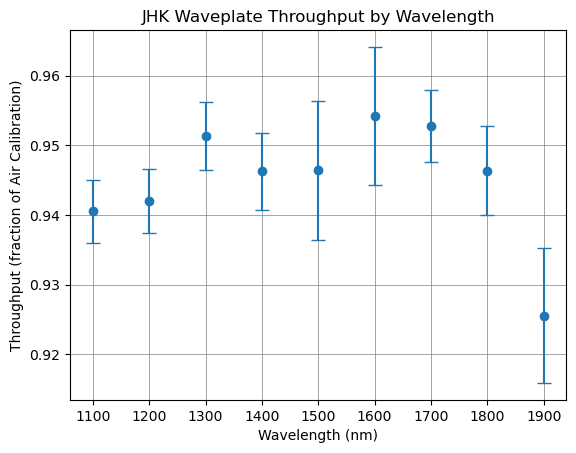

In [2]:
directory = 'D:\\20250514_NIRC2_JHK_Waveplate_Throughput'
wvls = ['1100','1200','1300','1400','1500','1600','1700','1800','1900']
tm.plot_thruput(directory, wvls)

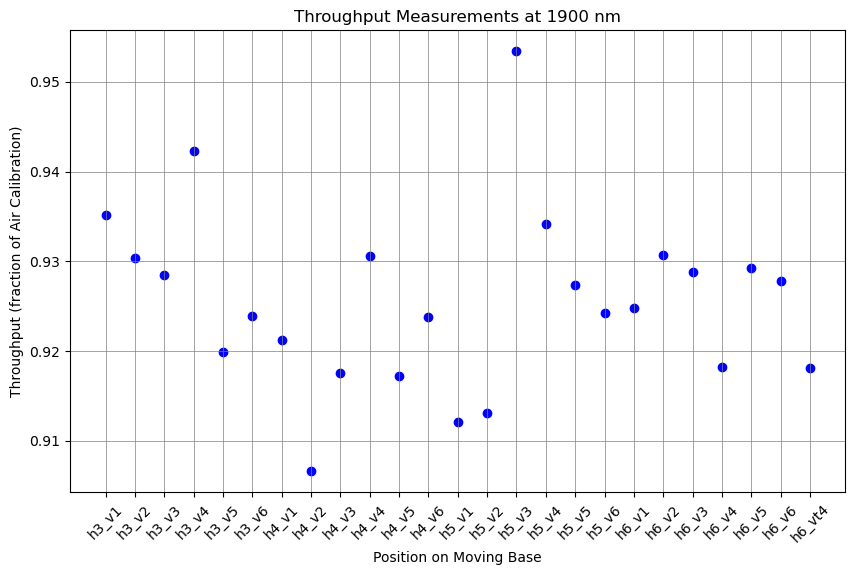

In [8]:
directory = 'D:\\20250514_NIRC2_JHK_Waveplate_Throughput'
wvl = '1900'
tm.plot_wavelength(directory, wvl)

In [7]:
directory = 'D:\\20250514_NIRC2_JHK_Waveplate_Throughput'
wvl = '1100'
thruput_list, wavelength  = tm.throughput_readout(directory, wvl)